<a href="https://colab.research.google.com/github/WoobeenJeong/CYP3A4_inhibition/blob/main/CYP3A4_inh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet --upgrade \
    dgl==1.1.2 dgllife==0.3.2 rdkit-pypi==2022.9.5 lightgbm

# Optuna
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 11.9 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, MACCSkeys, Lipinski, rdMolDescriptors
from rdkit.Chem.AllChem import EmbedMultipleConfs, UFFOptimizeMolecule
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.EState import Fingerprinter

from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor

import optuna
from optuna.pruners import MedianPruner
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from transformers import AutoTokenizer, AutoModel

from dgl.nn import GINConv, SumPooling
from dgllife.model import GINPredictor
from dgllife.utils import mol_to_bigraph, PretrainAtomFeaturizer, CanonicalAtomFeaturizer

In [ ]:
# --- Configuration ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# drive 연결

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 1. Load data
data_dir = '/content/drive/MyDrive/DACON/CYP3A4inh/'
os.makedirs(data_dir, exist_ok=True)

train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test = pd.read_csv(os.path.join(data_dir, 'test.csv'))

In [ ]:
# --- SMILES Augmentation ---
train['orig_id'] = np.arange(len(train))
augment_ratio = 5
augmented = []
for _, row in train.iterrows():
    smiles = row['Canonical_Smiles']
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        continue
    base_dict = row.to_dict()
    augmented.append(base_dict)
    for _ in range(augment_ratio):
        aug_smiles = Chem.MolToSmiles(mol, doRandom=True)
        new_row = base_dict.copy()
        new_row['Canonical_Smiles'] = aug_smiles
        augmented.append(new_row)
train = pd.DataFrame(augmented).reset_index(drop=True)
groups = train['orig_id'].values  # GroupKFold용


In [ ]:
train.shape

(10086, 2053)

In [ ]:
# --- ECFP ---
def get_ecfp(s, radius=2, n_bits=2048):
    try:
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            raise ValueError("Invalid SMILES")
        bitvect = AllChem.GetMorganFingerprintAsBitVect(
            mol, radius=radius, nBits=n_bits
        )
        return [int(bit) for bit in bitvect]

    except Exception:
        return [0] * EXPECTED_DIM

train_ecfp = pd.DataFrame(train['Canonical_Smiles'].apply(get_ecfp).tolist(), columns=[f'FP_{i}' for i in range(2048)])
test_ecfp = pd.DataFrame(test['Canonical_Smiles'].apply(get_ecfp).tolist(), columns=[f'FP_{i}' for i in range(2048)])

train = pd.concat([train, train_ecfp], axis=1)
test = pd.concat([test, test_ecfp], axis=1)

In [ ]:
# from rdkit import Chem, DataStructs
# from rdkit.Chem import AllChem
# import numpy as np
# import pandas as pd
# from sklearn.feature_selection import VarianceThreshold
# from sklearn.decomposition import TruncatedSVD
# import scipy.sparse as sp

# # --- 1) ECFP 생성 함수 ---
# def get_ecfp_arr(s: str, radius: int = 2, n_bits: int = 2048) -> np.ndarray:
#     mol = Chem.MolFromSmiles(s)
#     arr = np.zeros((n_bits,), dtype=int)
#     if mol is not None:
#         bitvect = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
#         DataStructs.ConvertToNumpyArray(bitvect, arr)
#     return arr

# # --- 2) 배치 단위로 ECFP DataFrame 만들기 ---
# fp_cols = [f'FP_{i}' for i in range(2048)]
# batch_size = 2000  # 한 번에 처리할 샘플 개수, 메모리에 맞춰 조정

# ecfp_frames = []
# for start in range(0, len(train), batch_size):
#     end = start + batch_size
#     chunk = train['Canonical_Smiles'].iloc[start:end]
#     mat = np.vstack(chunk.map(get_ecfp_arr).values)
#     df_chunk = pd.DataFrame(mat, columns=fp_cols, index=chunk.index)
#     ecfp_frames.append(df_chunk)

# train_ecfp = pd.concat(ecfp_frames, axis=0)
# ecfp_frames.clear()  # 메모리 해제

# # test도 동일하게 처리
# for start in range(0, len(test), batch_size):
#     end = start + batch_size
#     chunk = test['Canonical_Smiles'].iloc[start:end]
#     mat = np.vstack(chunk.map(get_ecfp_arr).values)
#     df_chunk = pd.DataFrame(mat, columns=fp_cols, index=chunk.index)
#     ecfp_frames.append(df_chunk)

# test_ecfp = pd.concat(ecfp_frames, axis=0)

# # --- sparsity 줄이기 옵션 3가지 (필요한 것만 주석 해제) ---
# # -----------------------------------------------------------------------------
# # Option 1) Near-zero-variance bit 제거
# # -----------------------------------------------------------------------------
# # selector = VarianceThreshold(threshold=0.001)
# # train_vt = selector.fit_transform(train_ecfp)
# # test_vt  = selector.transform(test_ecfp)
# # train_ecfp = pd.DataFrame(train_vt,
# #                           columns=selector.get_feature_names_out(),
# #                           index=train.index)
# # test_ecfp  = pd.DataFrame(test_vt,
# #                           columns=selector.get_feature_names_out(),
# #                           index=test.index)

# # -----------------------------------------------------------------------------
# # Option 2) Count-based Morgan fingerprint (useCounts=True)
# # -----------------------------------------------------------------------------
# # def get_ecfp_count(s: str, radius: int = 2, n_bits: int = 2048) -> np.ndarray:
# #     mol = Chem.MolFromSmiles(s)
# #     arr = np.zeros((n_bits,), dtype=int)
# #     if mol is not None:
# #         fp = AllChem.GetHashedMorganFingerprint(mol,
# #                                                 radius=radius,
# #                                                 nBits=n_bits,
# #                                                 useCounts=True)
# #         DataStructs.ConvertToNumpyArray(fp, arr)
# #     return arr
# #
# # ecfp_frames = []
# # for start in range(0, len(train), batch_size):
# #     chunk = train['Canonical_Smiles'].iloc[start:start+batch_size]
# #     mat = np.vstack(chunk.map(get_ecfp_count).values)
# #     ecfp_frames.append(pd.DataFrame(mat, columns=fp_cols, index=chunk.index))
# # train_ecfp = pd.concat(ecfp_frames, axis=0)
# # ecfp_frames.clear()
# #
# # for start in range(0, len(test), batch_size):
# #     chunk = test['Canonical_Smiles'].iloc[start:start+batch_size]
# #     mat = np.vstack(chunk.map(get_ecfp_count).values)
# #     ecfp_frames.append(pd.DataFrame(mat, columns=fp_cols, index=chunk.index))
# # test_ecfp = pd.concat(ecfp_frames, axis=0)

# # -----------------------------------------------------------------------------
# # Option 3) TruncatedSVD (희소 PCA)
# # -----------------------------------------------------------------------------
# # sparse_mat = sp.csr_matrix(train_ecfp.values)
# # svd = TruncatedSVD(n_components=200, algorithm='randomized', n_iter=5)
# # reduced = svd.fit_transform(sparse_mat)
# # train_reduced = pd.DataFrame(
# #     reduced,
# #     columns=[f'SVD_{i}' for i in range(reduced.shape[1])],
# #     index=train.index
# # )
# # test_reduced = pd.DataFrame(
# #     svd.transform(sp.csr_matrix(test_ecfp.values)),
# #     columns=train_reduced.columns,
# #     index=test.index
# # )
# # train_ecfp = train_reduced
# # test_ecfp  = test_reduced

# # --- 3) 최종 결합 ---
# train = pd.concat([train.drop(columns=fp_cols, errors='ignore'), train_ecfp], axis=1)
# test  = pd.concat([test .drop(columns=fp_cols, errors='ignore'), test_ecfp ], axis=1)

In [ ]:
# --- 분자 특성 추가 ---
def get_molecule_descriptors(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [0] * 2300

        # 1) 기본 descriptors
        basic = [
            Descriptors.MolWt(mol),
            Descriptors.MolLogP(mol),
            Descriptors.NumHAcceptors(mol),
            Descriptors.NumHDonors(mol),
            Descriptors.TPSA(mol),
            Descriptors.NumRotatableBonds(mol),
            Descriptors.NumAromaticRings(mol),
            Descriptors.NumHeteroatoms(mol),
            Descriptors.FractionCSP3(mol),
            Descriptors.NumAliphaticRings(mol),
            Lipinski.NumAromaticHeterocycles(mol),
            Lipinski.NumSaturatedHeterocycles(mol),
            Lipinski.NumAliphaticHeterocycles(mol),
            Descriptors.HeavyAtomCount(mol),
            Descriptors.RingCount(mol),
            Descriptors.NOCount(mol),
            Descriptors.NHOHCount(mol),
            Descriptors.NumRadicalElectrons(mol),
        ]

        # 2) PEOE_VSA (14차원)
        vsa = list(rdMolDescriptors.PEOE_VSA_Fingerprint(mol))

        # 3) EState indices
        estate = list(Fingerprinter.FingerprintMol(mol))

        # 4) Topological descriptors
        balaban = [rdMolDescriptors.CalcBalabanJ(mol)]
        wiener  = [rdMolDescriptors.CalcWienerIndex(mol)]

        # 5) Morgan + MACCS
        morgan_bits = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        morgan = [int(b) for b in morgan_bits.ToBitString()]
        maccs_bits = MACCSkeys.GenMACCSKeys(mol)
        maccs  = [int(b) for b in maccs_bits.ToBitString()]

        # 합치기
        all_feats = basic + vsa + estate + balaban + wiener + morgan + maccs
        return all_feats

    except:
        return [0] * 2300
        print_except

print("get_molecule_descriptors 추출 중...")
train_desc = np.array(train['Canonical_Smiles'].apply(get_molecule_descriptors).tolist())
test_desc = np.array(test['Canonical_Smiles'].apply(get_molecule_descriptors).tolist())

get_molecule_descriptors 추출 중...


In [ ]:
train_desc

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# np.save(os.path.join(data_dir, 'train_desc.npy'), train_desc)
# np.save(os.path.join(data_dir, 'test_desc.npy'), test_desc)

In [ ]:
train_desc = np.load(os.path.join(data_dir, 'train_desc.npy'))
test_desc = np.load(os.path.join(data_dir, 'test_desc.npy'))

In [ ]:
# !apt-get update && apt-get install -y openbabel

In [ ]:
# !apt-get update && apt-get install -y autodock-vina

In [ ]:
import os
import subprocess
import shutil
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, MACCSkeys
from rdkit.Chem.AllChem import EmbedMultipleConfs, UFFOptimizeMolecule

# --- 3D Shape Descriptors ---
def compute_3d_descriptors(smiles, num_confs=5):
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
    conf_ids = EmbedMultipleConfs(mol, numConfs=num_confs)
    sasa_vals, inertia_ratios = [], []
    for cid in conf_ids:
        UFFOptimizeMolecule(mol, confId=cid)
        # SASA
        sasa = rdMolDescriptors.CalcLabuteASA(mol)
        sasa_vals.append(sasa)
        # Principal Moments of Inertia
        pm1 = rdMolDescriptors.CalcPMI1(mol, confId=cid)
        pm2 = rdMolDescriptors.CalcPMI2(mol, confId=cid)
        pm3 = rdMolDescriptors.CalcPMI3(mol, confId=cid)
        ratio = pm1 / (pm2 + pm3) if (pm2 + pm3) > 0 else 0
        inertia_ratios.append(ratio)
    return [
        np.mean(sasa_vals), np.std(sasa_vals),
        np.mean(inertia_ratios), np.std(inertia_ratios)
    ]

# --- Vina Docking Score 계산 함수 ---
def compute_docking_score(smiles, receptor_pdbqt, output_dir="docking_out", center=(0,0,0), size=(20,20,20), timeout=120):
    os.makedirs(output_dir, exist_ok=True)
    # ligand PDBQT 생성
    mol = Chem.AddHs(Chem.MolFromSmiles(smiles))
    ligand_name = ''.join(c if c.isalnum() else '_' for c in smiles)[:50]
    pdb_file  = os.path.join(output_dir, f"{ligand_name}.pdb")
    pdbqt_file = pdb_file.replace('.pdb', '.pdbqt')
    Chem.MolToPDBFile(mol, pdb_file)
    # ligand preparation
    if shutil.which('prepare_ligand4.py'):
        subprocess.run(["prepare_ligand4.py", "-l", pdb_file, "-o", pdbqt_file], check=True, timeout=timeout)
    elif shutil.which('obabel'):
        subprocess.run(["obabel", pdb_file, "-O", pdbqt_file, "--partialcharge", "gasteiger"], check=True, timeout=timeout)
    else:
        return np.nan
    # Vina 도킹
    cmd = ["vina", "--receptor", receptor_pdbqt,
           "--ligand", pdbqt_file,
           "--out", os.path.join(output_dir, f"{ligand_name}_out.pdbqt"),
           "--log", os.path.join(output_dir, f"{ligand_name}.log"),
           "--center_x", str(center[0]), "--center_y", str(center[1]), "--center_z", str(center[2]),
           "--size_x", str(size[0]),   "--size_y", str(size[1]),   "--size_z", str(size[2])]
    try:
        result = subprocess.run(cmd, capture_output=True, text=True, check=True, timeout=timeout)
        for line in result.stdout.splitlines():
            if line.strip().startswith("1"):
                return float(line.split()[1])
    except subprocess.TimeoutExpired:
        return np.nan
    except Exception:
        return np.nan
    return np.nan

# 사용할 수 있는 receptor PDBQT 파일 사전
pdbqt_map = {
    '9BV5': 'receptor/9BV5.pdbqt',
    '9BV6': 'receptor/9BV6.pdbqt',
    '9BV7': 'receptor/9BV7.pdbqt',
    '9BV8': 'receptor/9BV8.pdbqt',
    '9BV9': 'receptor/9BV9.pdbqt',
    '9BVA': 'receptor/9BVA.pdbqt',
    '9BVB': 'receptor/9BVB.pdbqt',
    '9BVC': 'receptor/9BVC.pdbqt',
    '9MS1': 'receptor/9MS1.pdbqt'
}

# --- ECFP, 2D Descriptors 정의 ---
def get_ecfp(s, radius=2, n_bits=2048):
    try:
        mol = Chem.MolFromSmiles(s)
        if mol is None:
            return [0] * n_bits
        bitvect = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=n_bits)
        return [int(bit) for bit in bitvect]
    except Exception:
        return [0] * n_bits

def get_2d_descriptors(mol):
    return [
        Descriptors.MolWt(mol), Descriptors.MolLogP(mol),
        Descrip

        Descriptors.NumHAcceptors(mol), Descriptors.NumHDonors(mol),
        Descriptors.TPSA(mol), Descriptors.NumRotatableBonds(mol),
        Descriptors.NumAromaticRings(mol), Descriptors.NumHeteroatoms(mol),
        Descriptors.FractionCSP3(mol), Descriptors.NumAliphaticRings(mol),
        MACCSkeys.GenMACCSKeys(mol).ToBitString().count('1')
    ]

# --- 통합 Descriptor 함수 ---
def get_molecule_descriptors(smiles, pdb_ids=None):
    mol = Chem.MolFromSmiles(smiles)
    # 1) ECFP
    # ecfp = get_ecfp(smiles)
    # 2) 2D descriptors
    desc2d = get_2d_descriptors(mol) if mol else [0]*11
    # 3) 3D shape
    # desc3d = compute_3d_descriptors(smiles)
    # 4) Docking scores across ultiple receptors
    # docking = []
    # if pdb_ids:
    #     for pid in pdb_ids:
    #         receptor = pdbqt_map.get(pid)
    #         if receptor and os.path.exists(receptor):
    #             score = compute_docking_score(smiles, receptor)
    #         else:
    #             score = 0.0
    #         docking.append(score)
    # 합치기
    features = ecfp + desc2d + desc3d + docking
    return features

# --- 적용 예시 ---
pdb_ids = ['9BV5','9BV6','9BV7','9BV8','9BV9','9BVA','9BVB','9BVC','9MS1']
print("get_molecule_descriptors 추출 중...")
train_3d = np.array(train['Canonical_Smiles'].apply(lambda s: get_molecule_descriptors(s, pdb_ids)).tolist())
test_3d  = np.array(test['Canonical_Smiles'].apply(lambda s: get_molecule_descriptors(s, pdb_ids)).tolist())

get_molecule_descriptors 추출 중...


In [ ]:
# np.save(os.path.join(data_dir, 'train_3d.npy'), train_3d)
# np.save(os.path.join(data_dir, 'test_3d.npy'), test_3d)

In [ ]:
train_3d = np.load(os.path.join(data_dir, 'train_3d.npy'))
test_3d = np.load(os.path.join(data_dir, 'test_3d.npy'))

In [ ]:
# --- ChemBERTa Embedding ---
tokenizer = AutoTokenizer.from_pretrained('seyonec/ChemBERTa-zinc-base-v1')
model = AutoModel.from_pretrained('seyonec/ChemBERTa-zinc-base-v1')
model.eval()

def compute_smiles_embedding(smiles_list, batch_size=32):
    embs = []
    with torch.no_grad():
        for i in range(0, len(smiles_list), batch_size):
            toks = tokenizer(smiles_list[i:i+batch_size], return_tensors='pt', padding=True)
            out = model(**toks)
            embs.append(out.last_hidden_state[:,0,:].cpu().numpy())
    return np.vstack(embs)

train_smiles = train['Canonical_Smiles'].tolist()
train_emb = compute_smiles_embedding(train_smiles)
np.save(os.path.join(data_dir, 'train_emb.npy'), train_emb)
print('Train embeddings saved.')

test_smiles = test['Canonical_Smiles'].tolist()
test_emb = compute_smiles_embedding(test_smiles)
np.save(os.path.join(data_dir, 'test_emb.npy'), test_emb)
print('Test embeddings saved.')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/179M [00:00<?, ?B/s]

Train embeddings saved.
Test embeddings saved.


In [ ]:
train_emb = np.load(os.path.join(data_dir, 'train_emb.npy'))
test_emb = np.load(os.path.join(data_dir, 'test_emb.npy'))

In [ ]:
# --- GNN Embedding ---
node_featurizer = CanonicalAtomFeaturizer()

def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return mol_to_bigraph(mol, node_featurizer=node_featurizer)

print("GNN 임베딩 추출 중...")
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=128):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, x):
        return self.layers(x)

class GINBackbone(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()
        self.layers = nn.ModuleList()
        for hid_dim in hidden_dims:
            mlp = nn.Sequential(
                nn.Linear(input_dim, hid_dim),
                nn.ReLU(),
                nn.Linear(hid_dim, hid_dim)
            )
            self.layers.append(GINConv(mlp, 'sum'))
            input_dim = hid_dim
        self.pool = SumPooling()
    def forward(self, g, feats):
        h = feats
        for layer in self.layers:
            h = layer(g, h)
        hg = self.pool(g, h)
        return hg

gnn_backbone = GINBackbone(input_dim=node_featurizer.feat_size(), hidden_dims=[128,128,128])
mlp_predictor = MLP(input_dim=128, hidden_dim=256, output_dim=128)
model_gnn = nn.Sequential(gnn_backbone, mlp_predictor)
model_gnn.eval()

def get_gnn_features(df_smiles):
    graphs = [smiles_to_graph(s) for s in df_smiles]
    feats = []
    for g in graphs:
        if g is not None:
            with torch.no_grad():
                x = g.ndata['h'].float()
                hg = gnn_backbone(g, x)
                out = mlp_predictor(hg)
                feats.append(out.numpy())
        else:
            feats.append(np.zeros(128))
    return np.vstack(feats)

train_gnn = get_gnn_features(train['Canonical_Smiles'])
test_gnn = get_gnn_features(test['Canonical_Smiles'])

np.save(os.path.join(data_dir, 'train_gnn.npy'), train_gnn)
print('Train embeddings saved.')

np.save(os.path.join(data_dir, 'test_gnn.npy'), test_gnn)
print('Test embeddings saved.')

GNN 임베딩 추출 중...
Train embeddings saved.
Test embeddings saved.


In [ ]:
train_gnn = np.load(os.path.join(data_dir, 'train_gnn.npy'))
test_gnn = np.load(os.path.join(data_dir, 'test_gnn.npy'))

In [ ]:
# --- Scaling and Stacking ---

robs = RobustScaler()
stds = StandardScaler()
mmxs = MinMaxScaler()

# 1) Descriptor
# train_desc = stds.fit_transform(train_desc)
# test_desc = stds.transform(test_desc)

# 1) 3D까지 포함한 Descriptor
train_3d = robs.fit_transform(train_3d)
test_3d = robs.transform(test_3d)

# 2) ChemBERTa 임베딩
train_emb = robs.fit_transform(train_emb)
test_emb = robs.transform(test_emb)

# 3) GNN 임베딩
train_gnn = robs.fit_transform(train_gnn)
test_gnn = robs.transform(test_gnn)

# X_train = np.hstack([train_desc, train_emb, train_gnn])
# X_test = np.hstack([test_desc, test_emb, test_gnn])

X_train = np.hstack([train_3d, train_emb, train_gnn])
X_test = np.hstack([test_3d, test_emb, test_gnn])

In [ ]:
# # PCA 학습 및 train 임베딩 차원 축소
# pca = PCA(n_components=100)
# train_emb_pca = pca.fit_transform(train_emb)

# # PCA 모델 저장
# with open(os.path.join(data_dir, 'pca_model.pkl'), 'wb') as f:
#     pickle.dump(pca, f)

# # train 임베딩 PCA 결과 저장
# np.save(os.path.join(data_dir, 'train_emb_pca.npy'), train_emb_pca)
# print('PCA model and train_emb_pca saved.')

# # test 임베딩 로드 및 PCA 변환 후 저장
# test_emb = np.load(os.path.join(data_dir, 'test_emb.npy'))
# test_emb_pca = pca.transform(test_emb)
# np.save(os.path.join(data_dir, 'test_emb_pca.npy'), test_emb_pca)
# print('Test embeddings PCA transformed and saved.')

In [ ]:
# -- Scaffold 계산 --
def get_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return ""
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold)

train['scaffold'] = train['Canonical_Smiles'].apply(get_scaffold)

In [ ]:
# np.save(f"{data_dir}/X_train_final.npy", X_train)
# np.save(f"{data_dir}/X_test_final.npy", X_test)

In [ ]:
X_train = np.load(f"{data_dir}/X_train_final.npy")
X_test = np.load(f"{data_dir}/X_test_final.npy")

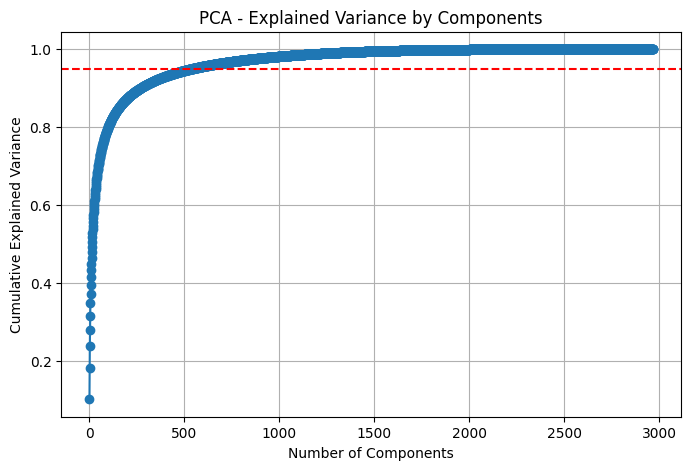

95% 이상의 분산을 설명하는 최적 차원 수: 542


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 예: 이미 스케일링된 데이터 X_scaled (train_desc 등)
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

# 누적 설명 분산 시각화
plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(cumsum)+1), cumsum, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--')  # 예: 95% 기준선
plt.title('PCA - Explained Variance by Components')
plt.show()

# 몇 번째 성분까지 누적 분산이 95%를 넘는지
n_components = np.argmax(cumsum >= 0.95) + 1
print(f"95% 이상의 분산을 설명하는 최적 차원 수: {n_components}")

In [ ]:
# y_train = train['Inhibition'].values
# groups = train['scaffold'].values

# # --- 평가 지표 ---
# def nrmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred)) / (y_true.max() - y_true.min())
# def final_score(y_true, y_pred):
#     A = nrmse(y_true, y_pred)
#     B, _ = pearsonr(y_true, y_pred)
#     return 0.5 * (1 - min(A, 1)) + 0.5 * B

# # --- Optuna + XGB ---
# sampler = optuna.samplers.TPESampler(seed=42)
# pruner  = MedianPruner(n_startup_trials=1, n_warmup_steps=1)
# study   = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int    ('n_estimators',   50, 300),
#         'max_depth':    trial.suggest_int    ('max_depth',      3, 12),
#         'learning_rate':trial.suggest_float  ('learning_rate',  1e-3, 0.1, log=True),
#         'subsample':    trial.suggest_float  ('subsample',      0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha':    trial.suggest_float  ('reg_alpha',      1e-8, 10.0, log=True),
#         'reg_lambda':   trial.suggest_float  ('reg_lambda',     1e-8, 10.0, log=True),
#         'random_state': 42,
#         'n_jobs':      -1
#     }

#     oof = np.zeros(len(y_train))
#     cv  = GroupKFold(n_splits=5)
#     for tr_idx, vl_idx in cv.split(X_train, y_train, groups):
#         model = XGBRegressor(**params)
#         model.fit(
#             X_train[tr_idx], y_train[tr_idx],
#             eval_set=[(X_train[vl_idx], y_train[vl_idx])],
#             verbose=False
#         )
#         oof[vl_idx] = model.predict(X_train[vl_idx])
#     return final_score(y_train, oof)

# # 최적화 실행
# study.optimize(objective, n_trials=5, timeout=3600)
# print('Best params:', study.best_trial.params)
# print('Best Score:', study.best_value)

In [ ]:
y_train = train['Inhibition'].values
groups = train['scaffold'].values

# --- 평가 지표 ---
def nrmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / (y_true.max() - y_true.min())
def final_score(y_true, y_pred):
    A = nrmse(y_true, y_pred)
    B, _ = pearsonr(y_true, y_pred)
    return 0.5 * (1 - min(A, 1)) + 0.5 * B

# --- 최적 PCA ---

pca = PCA(n_components=n_components, random_state=42)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced  = pca.transform(X_test)


In [ ]:
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.pipeline import make_pipeline

# --- Optuna + Stacking (ElasticNet + XGB) ---
sampler = optuna.samplers.TPESampler(seed=42)
pruner  = MedianPruner(n_startup_trials=1, n_warmup_steps=1)

study   = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
# study   = optuna.create_study(
#     directions=["maximize", "maximize"],  # (1-NRMSE), Pearson r
#     sampler=sampler,
#     pruner=pruner
# )


def objective(trial):
    enet_alpha = trial.suggest_float('enet_alpha', 1e-4, 10.0, log=True)
    enet_l1 = trial.suggest_float('enet_l1_ratio', 0.0, 1.0)

    xgb_params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42,
        'n_jobs': -1
    }

    # 개별 모델 정의
    enet = ElasticNet(alpha=enet_alpha, l1_ratio=enet_l1, random_state=42)
    xgb  = XGBRegressor(**xgb_params)

    # 스태킹 회귀기 정의
    model = StackingRegressor(
        estimators=[('enet', enet), ('xgb', xgb)],
        final_estimator=Ridge(),
        cv=3,
        n_jobs=-1,
        passthrough=False
    )

    # 교차 검증 평가
    oof = np.zeros(len(y_train))
    cv = GroupKFold(n_splits=3)

    for tr_idx, vl_idx in cv.split(X_train_reduced, y_train, groups):
        model.fit(X_train_reduced[tr_idx], y_train[tr_idx])
        oof[vl_idx] = model.predict(X_train_reduced[vl_idx])

    return final_score(y_train, oof)

    # for tr_idx, vl_idx in cv.split(X_train_reduced, y_train, groups):
    #     model.fit(X_train_reduced[tr_idx], y_train[tr_idx])
    #     oof[vl_idx] = model.predict(X_train_reduced[vl_idx])
    # A = nrmse(y_train, oof)             # NRMSE
    # B, _ = pearsonr(y_train, oof)       # Pearson r
    # return (1 - A, B)

# 최적화 실행
study.optimize(objective, n_trials=1, timeout=1800)
print('Best params:', study.best_trial.params)
print('Best Score:', study.best_value)

# for t in study.best_trials:
#     print(f"Params: {t.params}")
#     print(f"  1-NRMSE = {t.values[0]:.4f}, Pearson r = {t.values[1]:.4f}")
#     print(f"{0.5 * (1 - t.values[0]) + 0.5 * t.values[1]:.4f}")

In [ ]:
# # --- Optuna + LGB ---
# sampler = optuna.samplers.TPESampler(seed=42)
# pruner = MedianPruner(n_startup_trials=1, n_warmup_steps=1)
# study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 200),
#         'learning_rate': trial.suggest_float('lr', 1e-3, 5e-2, log=True),
#         'num_leaves': trial.suggest_int('leaves', 16, 64),
#         'min_child_samples': trial.suggest_int('min_child', 1, 10),
#         'min_split_gain': trial.suggest_float('gain', 0.0, 0.2),
#         'max_depth': -1
#     }
#     oof = np.zeros(len(y_train))
#     cv = GroupKFold(n_splits=3)
#     for tr_idx, vl_idx in cv.split(X_train, y_train, groups):
#         model = LGBMRegressor(**params, random_state=42, n_jobs=-1, verbose=-1)
#         model.fit(X_train[tr_idx], y_train[tr_idx])
#         oof[vl_idx] = model.predict(X_train[vl_idx])
#     return final_score(y_train, oof)

# study.optimize(objective, n_trials=10, timeout=10800)
# print('Best params:', study.best_trial.params)
# print('Best Score:', study.best_value)
# best_params = study.best_trial.params

In [ ]:
best_params = study.best_trial.params
save_path = os.path.join(data_dir, 'best_params.pkl')

with open(save_path, 'wb') as f:
    pickle.dump(best_params, f)

print(f"Best params saved to {save_path}")

Best params saved to /content/drive/MyDrive/DACON/CYP3A4inh/best_params.pkl


In [ ]:
import pickle

load_path = os.path.join(data_dir, 'best_params.pkl')

with open(load_path, 'rb') as f:
    best_params = pickle.load(f)

print("Loaded best params:", best_params)

Loaded best params: {'enet_alpha': 0.0074593432857265485, 'enet_l1_ratio': 0.9507143064099162, 'n_estimators': 233, 'max_depth': 8, 'learning_rate': 0.0020513382630874496, 'subsample': 0.5779972601681014, 'colsample_bytree': 0.5290418060840998, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}


In [ ]:
# param_fix = {
#     'lr': 'learning_rate',
#     'leaves': 'num_leaves',
#     'min_child': 'min_child_samples',
#     'gain': 'min_split_gain'
# }
# best_params_fixed = {param_fix.get(k, k): v for k, v in best_params.items()}

In [ ]:
# from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
# from sklearn.model_selection import GroupKFold
# from lightgbm import LGBMRegressor
# from sklearn.metrics import mean_squared_error

# oof_preds = np.zeros(len(y_train))
# gkf = GroupKFold(n_splits=3)

# for fold, (tr_idx, val_idx) in enumerate(gkf.split(X_train, y_train, groups)):
#     X_tr, X_vl = X_train[tr_idx], X_train[val_idx]
#     y_tr, y_vl = y_train[tr_idx], y_train[val_idx]

#     base_learners = [
#         ('lgb', LGBMRegressor(**best_params_fixed, random_state=fold)),
#         ('gbr', GradientBoostingRegressor(n_estimators=200, random_state=fold))
#     ]

#     stack = StackingRegressor(
#         estimators=base_learners,
#         final_estimator=LGBMRegressor(n_estimators=200, random_state=fold)
#     )

#     stack.fit(X_tr, y_tr)
#     oof_preds[val_idx] = stack.predict(X_vl)

#     print(f"Fold {fold} RMSE: {np.sqrt(mean_squared_error(y_vl, oof_preds[val_idx])):.4f}")
#     print(f"Fold {fold} Score: {final_score(y_vl, oof_preds[val_idx]):.4f}")

In [ ]:
# stack.fit(X_train, y_train)
# test_preds = stack.predict(X_test)

# submission = pd.DataFrame({'ID': test['ID'], 'Inhibition': test_preds})
# submission.to_csv(os.path.join(data_dir, 'submission_0714_04.csv'), index=False)
# print("Submission saved.")

### Ensemble 방식 적용

In [ ]:
from sklearn import set_config
set_config(enable_metadata_routing=False)

import time
from tqdm.auto import tqdm
import json
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# ── 베이스 러너 정의 ──
base_learners = [
    ('lgb', LGBMRegressor(**best_params, random_state=0)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=0)),
    ('gbr', GradientBoostingRegressor(n_estimators=200, random_state=0)),
    ('knn', KNeighborsRegressor(n_neighbors=10)),
    ('svr', SVR(kernel='rbf', C=1.0)),
    ('br', BayesianRidge())
]

# ── OOF feature 생성 함수 (cross_val_predict) ──
def make_oof_features(estimators, X, y, groups):

    gkf = GroupKFold(n_splits=3)
    n_learners = len(estimators)
    oof_feats = np.zeros((X.shape[0], n_learners))

    for i, (name, est) in enumerate(estimators):
        start = time.time()
        oof_feats[:, i] = cross_val_predict(
            est,
            X, y,
            groups=groups,
            cv=gkf,
            n_jobs=-1,
            method='predict'
        )
        elapsed = time.time() - start
        print(f"  • [{name}] done in {elapsed:.1f}s")
    return oof_feats

# ── 평가지표 ──
def final_score(y_true, y_pred):
    A = np.sqrt(mean_squared_error(y_true, y_pred)) / (y_true.max() - y_true.min())
    B = np.corrcoef(y_true, y_pred)[0, 1]
    return 0.5 * (1 - min(A, 1)) + 0.5 * B

# ── Optuna 메타‑러너 튜닝 ──
X_oof = make_oof_features(base_learners, X_train, y_train, groups)

def meta_objective(trial):
    alpha    = trial.suggest_float('meta_alpha',    1e-4, 10.0, log=True)
    l1_ratio = trial.suggest_float('meta_l1_ratio', 0.0, 1.0)
    meta = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10_000, random_state=42)
    # meta = TransformedTargetRegressor(
    #     regressor=ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10000, random_state=42),
    #     func=np.log1p, inverse_func=np.expm1
    # )                                         # 성능이 오히려 떨어지므로, skewed 아님

    # OOF CV로 메타-러너 검증
    gkf = GroupKFold(n_splits=3)
    oof_meta = np.zeros(len(y_train))
    for tr_idx, val_idx in gkf.split(X_oof, y_train, groups):
        meta.fit(X_oof[tr_idx], y_train[tr_idx])
        oof_meta[val_idx] = meta.predict(X_oof[val_idx])
    return final_score(y_train, oof_meta)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(meta_objective, n_trials=5, timeout=3600, show_progress_bar=True)

# ── 결과 저장 ──
best_meta = study.best_trial.params
to_save = {
    'base_best_params': best_params,
    'meta_alpha':    best_meta['meta_alpha'],
    'meta_l1_ratio': best_meta['meta_l1_ratio']
}
with open('ensemble_params.json', 'w') as f:
    json.dump(to_save, f, indent=2)

  • [lgb] done in 28.7s
  • [rf] done in 2195.8s
  • [gbr] done in 1804.6s
  • [knn] done in 19.9s
  • [svr] done in 565.9s


[I 2025-07-17 11:05:10,345] A new study created in memory with name: no-name-dbaf15d9-777b-4515-80f9-51d2049cb9a6


  • [br] done in 142.0s


  0%|          | 0/5 [00:00<?, ?it/s]

[I 2025-07-17 11:05:10,446] Trial 0 finished with value: 0.57892005997891 and parameters: {'meta_alpha': 0.0074593432857265485, 'meta_l1_ratio': 0.9507143064099162}. Best is trial 0 with value: 0.57892005997891.
[I 2025-07-17 11:05:10,485] Trial 1 finished with value: 0.579053756438749 and parameters: {'meta_alpha': 0.4570563099801455, 'meta_l1_ratio': 0.5986584841970366}. Best is trial 1 with value: 0.579053756438749.
[I 2025-07-17 11:05:10,528] Trial 2 finished with value: 0.5789173149853694 and parameters: {'meta_alpha': 0.0006026889128682511, 'meta_l1_ratio': 0.15599452033620265}. Best is trial 1 with value: 0.579053756438749.
[I 2025-07-17 11:05:10,565] Trial 3 finished with value: 0.5789172428159188 and parameters: {'meta_alpha': 0.00019517224641449495, 'meta_l1_ratio': 0.8661761457749352}. Best is trial 1 with value: 0.579053756438749.
[I 2025-07-17 11:05:10,607] Trial 4 finished with value: 0.5789500375873865 and parameters: {'meta_alpha': 0.10129197956845731, 'meta_l1_ratio': 

In [ ]:
def meta_objective(trial):
    alpha    = trial.suggest_float('meta_alpha',    1e-4, 10.0, log=True)
    l1_ratio = trial.suggest_float('meta_l1_ratio', 0.0, 1.0)
    meta = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, max_iter=10_000, random_state=42)

    # OOF CV로 메타-러너 검증
    gkf = GroupKFold(n_splits=3)
    oof_meta = np.zeros(len(y_train))
    for tr_idx, val_idx in gkf.split(X_oof, y_train, groups):
        meta.fit(X_oof[tr_idx], y_train[tr_idx])
        oof_meta[val_idx] = meta.predict(X_oof[val_idx])
    return final_score(y_train, oof_meta)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(meta_objective, n_trials=200, timeout=10800, show_progress_bar=True)

# ── 결과 저장 ──
best_meta = study.best_trial.params
to_save = {
    'base_best_params': best_params,
    'meta_alpha':    best_meta['meta_alpha'],
    'meta_l1_ratio': best_meta['meta_l1_ratio']
}
with open('ensemble_params.json', 'w') as f:
    json.dump(to_save, f, indent=2)

[I 2025-07-17 11:05:21,219] A new study created in memory with name: no-name-ad08021a-655b-416a-ad86-f6bbd4fe0d1c


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2025-07-17 11:05:21,305] Trial 0 finished with value: 0.57892005997891 and parameters: {'meta_alpha': 0.0074593432857265485, 'meta_l1_ratio': 0.9507143064099162}. Best is trial 0 with value: 0.57892005997891.
[I 2025-07-17 11:05:21,357] Trial 1 finished with value: 0.579053756438749 and parameters: {'meta_alpha': 0.4570563099801455, 'meta_l1_ratio': 0.5986584841970366}. Best is trial 1 with value: 0.579053756438749.
[I 2025-07-17 11:05:21,407] Trial 2 finished with value: 0.5789173149853694 and parameters: {'meta_alpha': 0.0006026889128682511, 'meta_l1_ratio': 0.15599452033620265}. Best is trial 1 with value: 0.579053756438749.
[I 2025-07-17 11:05:21,469] Trial 3 finished with value: 0.5789172428159188 and parameters: {'meta_alpha': 0.00019517224641449495, 'meta_l1_ratio': 0.8661761457749352}. Best is trial 1 with value: 0.579053756438749.
[I 2025-07-17 11:05:21,520] Trial 4 finished with value: 0.5789500375873865 and parameters: {'meta_alpha': 0.10129197956845731, 'meta_l1_ratio': 

In [ ]:
with open('ensemble_params.json', 'r') as f:
    saved = json.load(f)
print(saved)

{'base_best_params': {'n_estimators': 106, 'lr': 0.04123206532618727, 'leaves': 51, 'min_child': 6, 'gain': 0.031203728088487304}, 'meta_alpha': 9.968535139653175, 'meta_l1_ratio': 0.004616628626512666}


In [ ]:
# 1) Load saved params
with open('ensemble_params.json', 'r') as f:
    saved = json.load(f)

raw_params = saved['base_best_params']
corrected_params = {}
param_mapping = {
    'leaves': 'num_leaves',
    'lr': 'learning_rate',
    'min_child': 'min_child_samples'
}
for key, value in raw_params.items():
    if key in param_mapping:
        corrected_params[param_mapping[key]] = value
    elif key != 'gain':  # 'gain'은 제거
        corrected_params[key] = value


# 2) Reconstruct base learners
base_learners = [
    ('lgb', LGBMRegressor(**corrected_params, random_state=0)),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=0)),
    ('gbr', GradientBoostingRegressor(n_estimators=200, random_state=0)),
    ('knn', KNeighborsRegressor(n_neighbors=10)),
    ('svr', SVR(kernel='rbf', C=1.0)),
    ('br', BayesianRidge())
]

# 3) Reconstruct meta-learner
meta = ElasticNet(
    alpha=saved['meta_alpha'],
    l1_ratio=saved['meta_l1_ratio'],
    max_iter=10000,
    random_state=42
)

# 4) Fit base learners on full training data
for _, est in base_learners:
    est.fit(X_train, y_train)

# 5) Generate OOF-features (reuse the function from Cell 1)
X_oof = make_oof_features(base_learners, X_train, y_train, groups)

# 6) Train meta-learner on those OOF-features
meta.fit(X_oof, y_train)

# 7) Final OOF evaluation
oof_preds = meta.predict(X_oof)
A = np.sqrt(mean_squared_error(y_train, oof_preds)) / (y_train.max() - y_train.min())
B = np.corrcoef(y_train, oof_preds)[0, 1]
print(f"Final OOF Score: {0.5*(1-min(A,1))+0.5*B:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.573436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 72286
[LightGBM] [Info] Number of data points in the train set: 5043, number of used features: 4485
[LightGBM] [Info] Start training from score 33.221831
  • [lgb] done in 48.1s
  • [rf] done in 529.8s
  • [gbr] done in 538.2s
  • [knn] done in 6.9s
  • [svr] done in 191.4s
  • [br] done in 143.3s
Final OOF Score: 0.5904


In [ ]:
meta

In [ ]:
X_test_oof = np.column_stack([
    est.predict(X_test) for _, est in base_learners
])

# 3. Fit meta model correctly!
meta.fit(X_oof, y_train)  # ✅ 반드시 OOF 기반으로 학습해야 함

# 4. Predict test
test_preds = meta.predict(X_test_oof)

submission = pd.DataFrame({'ID': test['ID'], 'Inhibition': test_preds})
submission.to_csv(os.path.join(data_dir, 'submission_0715_03.csv'), index=False)
print("Submission saved.")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Submission saved.
